<a href="https://colab.research.google.com/github/zuhaib786/Disconinuity-Identification-in-Numerical-solutions-of-DEs/blob/main/U_Net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq ipython-autotime


     |████████████████████████████████| 1.6 MB 6.7 MB/s 


In [ ]:
%load_ext autotime

time: 476 µs (started: 2022-10-27 06:14:14 +00:00)


In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

time: 3.31 s (started: 2022-10-27 06:14:14 +00:00)


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

time: 1.36 ms (started: 2022-10-27 06:14:17 +00:00)


# U-Net Model
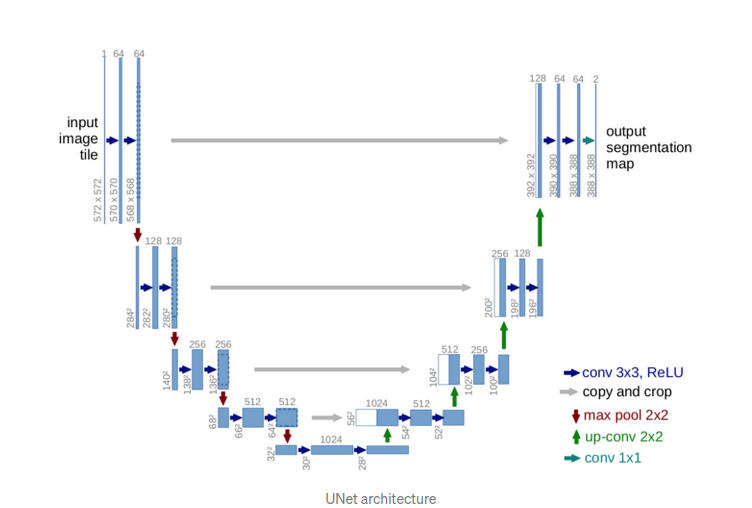

In [ ]:
class Legendre:
  def __init__(self):
    self.coeff = [[1], [0, 1], [-0.5, 0, 1.5], [0, -1.5, 0, 2.5], [0.375, 0, -3.75,0 , 4.375]]
  def calc(self, x, deg):
    data = self.coeff[deg]
    ans = 0
    mul = 1
    for i in data:
      ans += i * mul
      mul = mul * x
    return ans

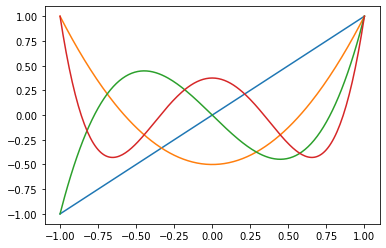

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
for deg in range(1,5):
  L = Legendre()
  x = np.linspace(-1, 1, 201)
  x = list(x)
  y = []
  for i in x:
    y.append(L.calc(i, deg))
  plt.plot(x, y)
plt.show()

In [ ]:
M = 128
class DataGenerator:
  def __init__(self, N_P = 4):
    self.N_P = 4
    self.L = Legendre()
    self.coeff_mat1  = self.genMat()
    self.coeff_mat2 = self.genMat()
    self.order = np.linspace(-1, 1, 128)
    self.mesh_x = np.linspace(-1, 1, 128)
    self.mesh_y = np.linspace(-1, 1, 128)
    self.mesh_x , self.mesh_y = np.meshgrid(self.mesh_x, self.mesh_y)
  def calc(self, mat):
    ans = np.zeros((128, 128))
    data = []
    if mat == 1:
      data = self.coeff_mat1
    else:
      data = self.coeff_mat2 

    for i in range(self.N_P + 1):
      for j in range(self.N_P  +1 - i):
        A = self.L.calc(self.mesh_x, i)
        B = self.L.calc(self.mesh_y, j)
        ans += data[i][j] *(A*B)
    return ans
  def lineCut(self):
    theta = np.random.uniform(0, 2*math.pi)
    x_0, y_0 = np.random.choice(self.order , 1), np.random.choice(self.order, 1)
    x_0 = list(x_0)[0]
    y_0 = list(y_0)[0]
    return self.lineToBinaryMat(x_0, y_0, theta) 
  def LineCalc(self, x_0, y_0, theta, x, y):
    return np.cos(theta) * (x - x_0) + np.sin(theta) * (y - y_0)
  def circCut(self):
    r = np.random.uniform(1e-2, 3)
    x_0, y_0 = np.random.choice(self.order , 1), np.random.choice(self.order, 1)
    x_0 = list(x_0)[0]
    y_0 = list(y_0)[0]
    x_0, y_0 = 0,0
    return self.cricToBinaryMat(x_0, y_0, r)
  def lineToBinaryMat(self, x_0, y_0, theta):
    A = self.LineCalc(x_0, y_0, theta, self.mesh_x, self.mesh_y)
    eps = 2e-2
    # print(A)
    # print(np.sum(abs(A)<=eps))
    return A >= 0,np.abs(A) <= eps 
  def CircCalc(self, x_0, y_0, r):
    return (self.mesh_x - x_0) * (self.mesh_x - x_0) + (self.mesh_y - y_0) * (self.mesh_y - y_0) - r
  def cricToBinaryMat(self, x_0, y_0, r):
    A = self.CircCalc(x_0, y_0, r)
    eps = 2e-2
    return A>=0 , np.abs(A) <= eps
  def genMat(self):
    data = np.random.normal(0, 1, size=(128, 128))
    return data
  def DataPointLine(self):
    self.mat1 = self.genMat()
    self.mat2 = self.genMat()
    ans1  = self.calc(1)
    ans2 = self.calc(2)
    y, label = self.lineCut()
    ans = ans1 * y + ans2 *( 1- y)
    return ans, y
  def DataPointCirc(self):
    self.mat1 = self.genMat()
    self.mat2 = self.genMat()
    ans1 = self.calc(1)
    ans2 = self.calc(2)
    y, label = self.circCut()
    ans = ans1 * y + ans2 * ( 1- y)
    return ans, y




time: 35.1 ms (started: 2022-10-27 06:27:42 +00:00)


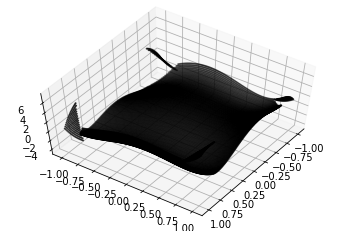

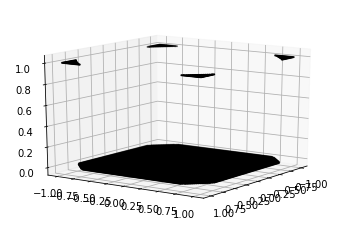

time: 1.21 s (started: 2022-10-27 06:27:52 +00:00)


In [ ]:
d = DataGenerator()
ans, y = d.DataPointCirc()


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(d.mesh_x, d.mesh_y, ans,color = 'black', s =1)
ax.view_init(60, 35)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(d.mesh_x, d.mesh_y, y,color = 'black', s = 1)
ax.view_init(15, 35)


In [ ]:
Di = {}
for i in range(128 * 128):
  Di[i] = []



time: 7.18 ms (started: 2022-10-27 06:27:49 +00:00)


In [ ]:
def getData():
  import random
  ydf = pd.DataFrame.from_dict(Di)
  xdf = pd.DataFrame.from_dict(Di)
  j = 0
  for j in range(500) :
    a = random.randint(1, 10)%2
    ans, y = 0, 0
    if a %2 == 0:
      ans, y = d.DataPointCirc()
    else:
      ans, y = d.DataPointLine()
    xdf.loc[j] = ans.reshape(M * M)
    ydf.loc[j] = y.reshape(M * M)
  return xdf, ydf

  

time: 1.9 ms (started: 2022-10-27 06:28:03 +00:00)


In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x



time: 1.77 ms (started: 2022-10-27 06:28:06 +00:00)


In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    input_img_resh = Reshape((M, M, 1))(input_img)
    c1 = conv2d_block(input_img_resh, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    outputs = Reshape((M*M, 1))(outputs)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

time: 8.4 ms (started: 2022-10-27 06:38:44 +00:00)


In [ ]:
input_img = Input(M*M, name='img')

model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

time: 566 ms (started: 2022-10-27 06:38:45 +00:00)


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 16384)]      0           []                               
                                                                                                  
 reshape_4 (Reshape)            (None, 128, 128, 1)  0           ['img[0][0]']                    
                                                                                                  
 conv2d_108 (Conv2D)            (None, 128, 128, 16  160         ['reshape_4[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_103 (Batch  (None, 128, 128, 16  64         ['conv2d_108[0][0]']       

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-u-net.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

time: 1.4 ms (started: 2022-10-27 06:38:53 +00:00)


In [ ]:
from tqdm import tqdm
X_valid, y_valid = getData()
for i in tqdm(range(1)):
  X_train, y_train = getData()
  results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,validation_data=(X_valid, y_valid))

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.9050
Epoch 1: val_loss improved from inf to 0.77153, saving model to model-u-net.h5
16/16 [==============================] - 70s 4s/step - loss: 0.2998 - accuracy: 0.9050 - val_loss: 0.7715 - val_accuracy: 0.7062 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9882
Epoch 2: val_loss improved from 0.77153 to 0.30687, saving model to model-u-net.h5
16/16 [==============================] - 67s 4s/step - loss: 0.1288 - accuracy: 0.9882 - val_loss: 0.3069 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9927
Epoch 3: val_loss did not improve from 0.30687
16/16 [==============================] - 68s 4s/step - loss: 0.1010 - accuracy: 0.9927 - val_loss: 0.3937 - val_accuracy: 0.8479 - lr: 0.0010
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 0.0855 - accura

100%|██████████| 1/1 [11:27<00:00, 687.42s/it]

time: 11min 41s (started: 2022-10-27 06:38:54 +00:00)


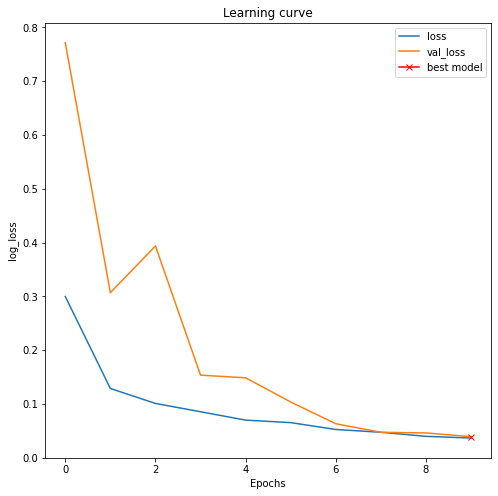

time: 217 ms (started: 2022-10-27 06:50:51 +00:00)


In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive
time: 22.6 s (started: 2022-10-27 06:51:25 +00:00)


In [ ]:
!cp   "/content/model-u-net.h5" -r      "/content/gdrive/MyDrive/SemVI"

time: 185 ms (started: 2022-10-27 06:52:47 +00:00)


In [ ]:
xdf, ydf = getData()
pred = model.predict(xdf)

16/16 [==============================] - 13s 820ms/step
time: 37.5 s (started: 2022-10-27 06:55:10 +00:00)


# Visualising the performance of the model

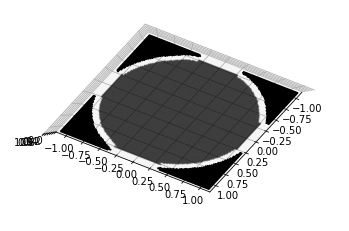

time: 1.27 s (started: 2022-10-27 07:03:25 +00:00)


In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(d.mesh_x, d.mesh_y, pred[30].reshape(128, 128)>0.8,color = 'black', s =1)
# ax.scatter3D(d.mesh_x, d.mesh_y, xdf.iloc[0].values.reshape(101, 101),color = 'black', s =1)
ax.view_init(90, 35)

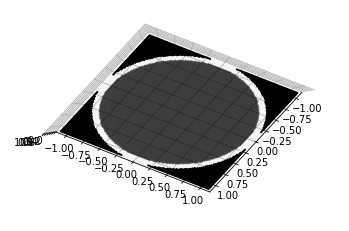

time: 664 ms (started: 2022-10-27 06:56:48 +00:00)


In [ ]:
# M = 12
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(d.mesh_x, d.mesh_y, ydf.iloc[0].values.reshape(101, 101),color = 'black', s =1)
ax.scatter3D(d.mesh_x, d.mesh_y, ydf.iloc[30].values.reshape(128, 128),color = 'black', s =1)
ax.view_init(90, 35)

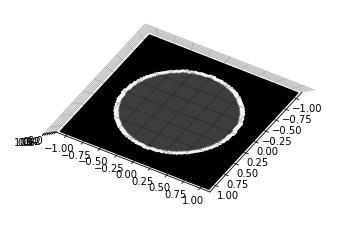

time: 1.04 s (started: 2022-10-27 08:02:28 +00:00)


In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(d.mesh_x, d.mesh_y, pred[50].reshape(128, 128)>0.8,color = 'black', s =1)
# ax.scatter3D(d.mesh_x, d.mesh_y, xdf.iloc[0].values.reshape(101, 101),color = 'black', s =1)
ax.view_init(90, 35)

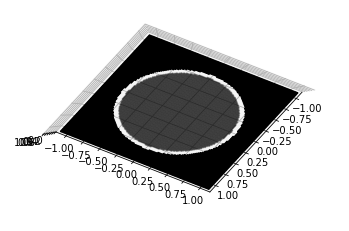

time: 876 ms (started: 2022-10-27 08:02:30 +00:00)


In [ ]:
# M = 12
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(d.mesh_x, d.mesh_y, ydf.iloc[0].values.reshape(101, 101),color = 'black', s =1)
ax.scatter3D(d.mesh_x, d.mesh_y, ydf.iloc[50].values.reshape(128, 128),color = 'black', s =1)
ax.view_init(90, 35)

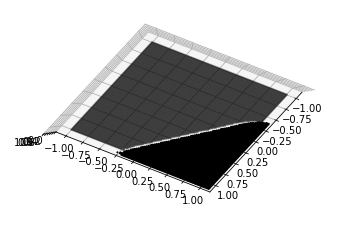

time: 1.02 s (started: 2022-10-27 08:03:03 +00:00)


In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(d.mesh_x, d.mesh_y, pred[85].reshape(128, 128)>0.8,color = 'black', s =1)
# ax.scatter3D(d.mesh_x, d.mesh_y, xdf.iloc[0].values.reshape(101, 101),color = 'black', s =1)
ax.view_init(90, 35)

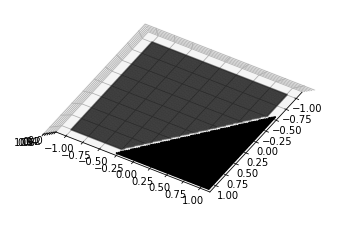

time: 924 ms (started: 2022-10-27 08:03:05 +00:00)


In [ ]:
# M = 12
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(d.mesh_x, d.mesh_y, ydf.iloc[0].values.reshape(101, 101),color = 'black', s =1)
ax.scatter3D(d.mesh_x, d.mesh_y, ydf.iloc[85].values.reshape(128, 128),color = 'black', s =1)
ax.view_init(90, 35)

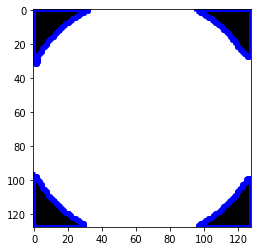

time: 412 ms (started: 2022-10-27 08:13:38 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


def get_all_edges(bool_img):
    """
    Get a list of all edges (where the value changes from True to False) in the 2D boolean image.
    The returned array edges has he dimension (n, 2, 2).
    Edge i connects the pixels edges[i, 0, :] and edges[i, 1, :].
    Note that the indices of a pixel also denote the coordinates of its lower left corner.
    """
    edges = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            edges.append(np.array([[i, j+1],
                                   [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            edges.append(np.array([[i+1, j],
                                   [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            edges.append(np.array([[i, j],
                                   [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            edges.append(np.array([[i, j],
                                   [i, j+1]]))

    if not edges:
        return np.zeros((0, 2, 2))
    else:
        return np.array(edges)


def close_loop_edges(edges):
    """
    Combine thee edges defined by 'get_all_edges' to closed loops around objects.
    If there are multiple disconnected objects a list of closed loops is returned.
    Note that it's expected that all the edges are part of exactly one loop (but not necessarily the same one).
    """

    loop_list = []
    while edges.size != 0:

        loop = [edges[0, 0], edges[0, 1]]  # Start with first edge
        edges = np.delete(edges, 0, axis=0)

        while edges.size != 0:
            # Get next edge (=edge with common node)
            ij = np.nonzero((edges == loop[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                loop.append(loop[0])
                # Uncomment to to make the start of the loop invisible when plotting
                # loop.append(loop[1])
                break

            loop.append(edges[i, (j + 1) % 2, :])
            edges = np.delete(edges, i, axis=0)

        loop_list.append(np.array(loop))

    return loop_list


def plot_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    edges = get_all_edges(bool_img=bool_img)
    edges = edges - 0.5  # convert indices to coordinates; TODO adjust according to image extent
    outlines = close_loop_edges(edges=edges)
    cl = LineCollection(outlines, **kwargs)
    ax.add_collection(cl)

plt.figure()
array = pred[77].reshape(128, 128)>=0.7
plt.imshow(array, cmap='binary')
plot_outlines(array.T, lw=5, color='b')

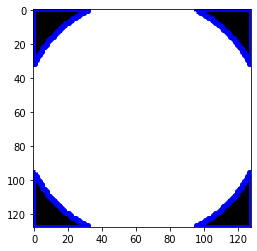

time: 351 ms (started: 2022-10-27 08:14:09 +00:00)


In [ ]:
plt.figure()
array = ydf.iloc[77].values.reshape(128, 128)
plt.imshow(array, cmap='binary')
plot_outlines(array.T, lw=5, color='b')